# FAIKR module 3 project

#Lorenzo Venieri
#Luca Zucchini

## Introduction

Diabetes is a serious disease affecting millions of people across the entire world. Thus, correct and timely prediction of this disease is very important due to the complications it can have in the case of other life-threatening diseases.

Objective of this project...

TODO:
-Aggiungere funzione per trovare correlazione tra features
-Considerare il fatto che il diabete causa durezza della pella, ma quest'ultima non è direttamente causa di diabete (=> != <=>)+
-Piccola spiegazione del ragionamento dietro le correlazioni NON trovate
-Fattore di rischio
-


In [ ]:
!pip install pgmpy

#prva

## Dataset

768 rows, 9 columns

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.
From the data set in the (.csv) File We can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).

We have 9 different attributes:
1. Pregnancies: number of pregnancies
2. Glucose: plasma glucose concentrarion 
3. BloodPressure: diastolic blood pressure mm/Hg
4. SkinThickness: triceps skin fold thickness (mm)
5. Insulin: insulin in U/mL
6. BMI: Body mass index (weight in kg/(height in m)^2)
7. Diabetes Pedigree Function: scores likelihood of diabetes based on family history
8. Age: age of the person (years)
9. Outcome: patient has diabetes (0 = No, 1 = Yes)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

df_raw = pd.read_csv("data/diabetes.csv")
df_raw.head()

## Exploratory Data Analysis

In [ ]:
df_raw.info()

In [ ]:
#Diabetes distribution in the dataset

df_raw['Outcome'].value_counts()

In our dataset there are 268 patients with diabetes and 500 without. The classes are imbalanced: only about 35% of the entries have diabetes.

In [ ]:
#Visualization of the other 8 (continuous) features

fig, axs = plt.subplots(4, 2, figsize=(18,16))
axs = axs.flatten()
sns.distplot(df_raw['Pregnancies'],rug=True,ax=axs[0])
sns.distplot(df_raw['Glucose'],rug=True,ax=axs[1])
sns.distplot(df_raw['BloodPressure'],rug=True,ax=axs[2])
sns.distplot(df_raw['SkinThickness'],rug=True,ax=axs[3])
sns.distplot(df_raw['Insulin'],rug=True,ax=axs[4])
sns.distplot(df_raw['BMI'],rug=True,ax=axs[5])
sns.distplot(df_raw['DiabetesPedigreeFunction'],rug=True,ax=axs[6])
sns.distplot(df_raw['Age'],rug=True,ax=axs[7])
plt.show()

In [ ]:
df_raw.corr()

Vediamo che il dataset è sbilanciato

In [ ]:
print("Numero di outcome seza diabete", (df_raw["Outcome"] == 0).sum())
print("Numero di outcome con diabete", (df_raw["Outcome"] == 1).sum())

Vediamo che ci sono tati valori nulli nel dataset. Sarebbero da togliere dato che sono dei NaN. Allo stesso tempo possiamo usare questa cosa per iniziare un downsample dei dati con Outcome '0'

In [38]:
for item in df_raw.columns:
    counter = 0
    for i in range(len(df_raw[item])):
        if df_raw[item][i] == 0 and df_raw["Outcome"][i] == 0:
            counter += 1
    print("nella colonna", item,"ci sono ",counter,"righe da eliminare che possono semplicemente essere downsamplate")

    - nella colonna  Pregnancies  sono presenti questi zeri
111
e questi sono tutti i valori disponibili:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]
---------------------------
    - nella colonna  Glucose  sono presenti questi zeri
5
e questi sono tutti i valori disponibili:
[  0  44  56  57  61  62  65  67  68  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 186 187 188
 189 190 191 193 194 195 196 197 198 199]
---------------------------
    - nella colonna  BloodPressure  sono presenti questi zeri
35
e questi sono tutti i valori disponibili:
[  0  24  30  38  40  44 

In [40]:
for item in df_raw.columns:
    print("valori di ",item)
    temp = df_raw[item].unique()
    temp.sort()
    #print(df_raw[item].unique())
    print(temp)
    print("----------------------")
    #
    #chiedere a Sten dei bin sensati per questi valori

valori di  Pregnancies
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]
----------------------
valori di  Glucose
[  0  44  56  57  61  62  65  67  68  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 186 187 188
 189 190 191 193 194 195 196 197 198 199]
----------------------
valori di  BloodPressure
[  0  24  30  38  40  44  46  48  50  52  54  55  56  58  60  61  62  64
  65  66  68  70  72  74  75  76  78  80  82  84  85  86  88  90  92  94
  95  96  98 100 102 104 106 108 110 114 122]
----------------------
valori di  SkinThickness
[ 0  7  8 10 11 12 13 14 15 16 17 18 19 2

Togliamo le righe che hanno un valore nullo aka NaN e un outcome '0'

In [ ]:
df_clean = df_raw.copy(deep=True)

In [ ]:
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI','Age']
for item in columns_to_clean:
    drop_list = []
    for i in range(len(df_clean[item])):
        if df_clean[item][i] == 0 and df_clean["Outcome"][i] == 0:
            drop_list.append(i)
    print("SIUUUM")
    df_clean.drop(labels= drop_list, axis= 0, inplace= True)
    df_clean.reset_index(drop=True, inplace=True)


SIUUUM
SIUUUM
SIUUUM
SIUUUM
SIUUUM
SIUUUM


In [ ]:
df_clean.shape

Abbiamo tolto un po di roba, adiamo sia a vedere se e quanto è sbilanciato il dataset che a togliere le restati righe che hanno un NaN

In [ ]:
print("Numero di outcome seza diabete", (df_clean["Outcome"] == 0).sum())
print("Numero di outcome con diabete", (df_clean["Outcome"] == 1).sum())

Controllo sull'insulina e sul tipo di diabete

In [ ]:
count_1 = 0
count_2 = 1
for i in range(df_clean.shape[0]):
    if df_clean["Insulin"][i] < 1 and df_clean["Outcome"][i] == 1 :
        count_1 += 1
    if df_clean["Insulin"][i] > 200 and df_clean["Outcome"][i] == 1:
        count_2 += 1
print("presumibilmente ci sono ",count_1,"pazienti con diabete di tipo 1")
print("presumibilmente ci sono ",count_2,"pazienti con diabete di tipo 2")

Togliamo ora i restanti NaN senza però adare a toccare quelli dell'insulina ( presumiamo siano registrati nulli ) 

In [46]:
for item in df_clean.columns:
    print("    - nella colonna ", item," sono presenti questi zeri")
    print((df_clean[item] == 0).sum())

    - nella colonna  Pregnancies  sono presenti questi zeri
75
    - nella colonna  Glucose  sono presenti questi zeri
2
    - nella colonna  BloodPressure  sono presenti questi zeri
16
    - nella colonna  SkinThickness  sono presenti questi zeri
88
    - nella colonna  Insulin  sono presenti questi zeri
138
    - nella colonna  BMI  sono presenti questi zeri
2
    - nella colonna  DiabetesPedigreeFunction  sono presenti questi zeri
0
    - nella colonna  Age  sono presenti questi zeri
0
    - nella colonna  Outcome  sono presenti questi zeri
262


In [ ]:
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI','Age']

for item in columns_to_clean:
    drop_list = []
    for i in range(len(df_clean[item])):
        if df_clean[item][i] == 0 :
            drop_list.append(i)
    print("SIUUUM")
    df_clean.drop(labels= drop_list, axis= 0, inplace= True)
    df_clean.reset_index(drop=True, inplace=True)

Bene, andiamo a vedere cosa rimane del dataset originario

In [ ]:
print("Numero di outcome seza diabete", (df_clean["Outcome"] == 0).sum())
print("Numero di outcome con diabete", (df_clean["Outcome"] == 1).sum())

Come notiamo c'è ancora da fare un downsample per bilanciare il dataset

In [ ]:
from sklearn.utils import resample

In [ ]:
df_positive_outcome = df_clean[df_clean["Outcome"] == 1]
df_negative_outcome = df_clean[df_clean["Outcome"] == 0]
#-----------

df_negative_outcome_downsampled = resample(df_negative_outcome,
             replace=True,
             n_samples=len(df_positive_outcome),
             random_state=42)
print(df_negative_outcome_downsampled.shape)
#-----------------

df_balanced = pd.concat([df_negative_outcome_downsampled, df_positive_outcome])
#-----------

print("Numero di outcome seza diabete", (df_balanced["Outcome"] == 0).sum())
print("Numero di outcome con diabete", (df_balanced["Outcome"] == 1).sum())


Bene, ora il dataset è bilanciato, non resta che binnarizzarlo

In [ ]:
#Printing the min and max values of age in order to better discretize the age parameter
print('Age range is: ', np.min(df_raw['Age']), ' - ', np.max(df_raw['Age']))

## Network


"In this chapter both the structure of the network, created from scratch by analyzing scientific papers related to the topic, and the parameter learning process are taken into account.

In particular, a variety of methods related to the analysis of Bayesian Networks are explored."

### Showing the network

A graphical preliminary overview of the network is shown using the visual library of pgmpy, the acronyms related to dataset attributes are the followings:

...


In [ ]:
!pip install daft

In [ ]:
import daft
import matplotlib.pyplot as plt
from daft import PGM

pgm = PGM()

pgm.add_node(daft.Node('Pr', "Pr", 1, 4))
pgm.add_node(daft.Node('DPF', "DPF", 2, 4))
pgm.add_node(daft.Node('Age', "Age", 3, 4))

pgm.add_node(daft.Node('Diab', "Diab", 2, 3))

pgm.add_node(daft.Node('Glu', "Glu", 1, 2))
pgm.add_node(daft.Node('Ins', "Ins", 2, 2))
pgm.add_node(daft.Node('ST', "ST", 3, 2))
pgm.add_node(daft.Node('BP', "BP", 4, 2))

pgm.add_node(daft.Node('BMI', "BMI", 1.5, 1))

pgm.add_edge('Pr', 'Diab')
pgm.add_edge('DPF', 'Diab')
pgm.add_edge('Age', 'Diab')
pgm.add_edge('Diab', 'Glu')
pgm.add_edge('Diab', 'Ins')
pgm.add_edge('Diab', 'ST')
pgm.add_edge('Diab', 'BP')
pgm.add_edge('Glu', 'BMI')
pgm.add_edge('Ins', 'BMI')

pgm.render()
plt.show()

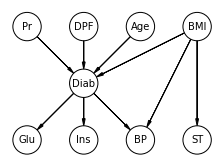

In [49]:
pgm = PGM()

pgm.add_node(daft.Node('Pr', "Pr", 1, 3))
pgm.add_node(daft.Node('DPF', "DPF", 2, 3))
pgm.add_node(daft.Node('Age', "Age", 3, 3))
pgm.add_node(daft.Node('BMI', "BMI", 4, 3))

pgm.add_node(daft.Node('Diab', "Diab", 2, 2))

pgm.add_node(daft.Node('Glu', "Glu", 1, 1))
pgm.add_node(daft.Node('Ins', "Ins", 2, 1))
pgm.add_node(daft.Node('BP', "BP", 3, 1))
pgm.add_node(daft.Node('ST', "ST", 4, 1))

pgm.add_edge('Pr', 'Diab')
pgm.add_edge('DPF', 'Diab')
pgm.add_edge('Age', 'Diab')
pgm.add_edge('BMI','Diab')
pgm.add_edge('BMI','ST')
pgm.add_edge('BMI', 'BP')
pgm.add_edge('Diab', 'Glu')
pgm.add_edge('Diab', 'Ins')
pgm.add_edge('Diab', 'BP')

pgm.render()
plt.show()

Examples of connections between nodes (e.g. direct cause, causal trail) refering to this specific Network are here shown:

#Direct cause

#Causal trail

#Common effect

## Creating the network

Connections between nodes have been implemented from scratch refering to a variety of scientific medical sources. Being the causal links in the medical field particularly challenging to model (i.e. often a huge variety of attributes are interlaced, causing directly or indirectly effects on each others) in this work only links that have been considered particularly relevant were defined.

Some of the connections are here explained and referenced:


In [ ]:
from pgmpy.models import BayesianModel

...

###Analyzing the network

Follows a series of experiments done on the network by applying a variety of methods provided by the pgmpy library in order to see in practice all the concepts addressed during the course.

In [ ]:
# Showing all the nodes of the model
model.nodes()

In [ ]:
# Showing all the edges of the model
model.edges()

In [ ]:
# Local independecies of a single node
model.local_independencies("high_blood_pressure")

In [ ]:
# Checking d-separation between variables with and without evidence
# Two sets of nodes X, Y are d-separated given Z if there is no active trail between any X ∈ X and Y ∈ Y given Z

print(model.is_dconnected("high_blood_pressure", "creatinine_phosphokinase"))
print(model.is_dconnected("serum_sodium", "diabetes",observed=["anaemia"] ))

In [ ]:
# Function is_irrelevant made from scratch by the definition of irrelevance given during the course 

def is_irrelevant (node1,node2,evidence):
  if ((node2 in (model.get_ancestral_graph(node1)and model.get_ancestral_graph(evidence))) and model.is_dconnected(node1, node2,observed=evidence )):
    print("The node {0} is not irrelevant with resepect to {1}, given the evidence {2}.".format(node1, node2, evidence))
  else:
    print("The node {0} is irrelevant with resepect to {1}, given the evidence {2}".format(node1, node2, evidence))


is_irrelevant("ejection_fraction", "diabetes", "heart_failure")

In [ ]:
# Checking active trails from high blood pressure given the evidence diabetes
model.active_trail_nodes('high_blood_pressure', observed='diabetes')

In [ ]:
# Checking the markov blanket of the node heart failure
model.get_markov_blanket("heart_failure")

### Parameter learning

Learning Bayesian networks from data, knowing the structure of the network, boils down to parameter estimation. In pgmpy a variety of estimators is available, going from IVestimator to SEMestimator, but the main choice for this problem fell on two of them: Maximum Likelihood and Bayesian Estimator.

MLE, which depends solely on the outcomes of observed data, could be a reasonable simple starting point, however, it is notorious for becoming easily biased when the data is minimal. Moreover, in situations where observed data is sparse, Bayesian estimation’s incorporation of prior knowledge can help in attaining a more accurate model. 

On the other hand, unreliable priors can lead to a slippery slope of highly biased models that require large amounts of seen data to remedy; so priors need to be well defined and contain relevant insight to the problem in order to avoid that. 

Taken into consideration pros and cons of both approaches, given the minimal dataset used for this work the Bayesian Estimator is choosen.

Pgmpy also offer a variety of possible priors, among them a possible choice is Bayesian Dirichlet equivalent uniform prior (BDeu), choosen with its default settings (i.e. equivalent_sample_size equal to 5).

In the following cell the parameter estimation process takes place and the learned CPTs are shown.

In [ ]:
from pgmpy.estimators import BayesianEstimator

model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

In [ ]:
# Checking the validity of the model 
# This method checks if the sum of the probabilities for each state is equal to 1 (tol=0.01) and if the CPDs associated with nodes are consistent with their parents.
model.check_model()